In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time, datetime

import sys
sys.path.append('/mnt/disk1/project/SMhospital/capsule/ce_packages')
from ce_utils import load_path, train_valid_split, damped_exp_LR, load_random_minibatch, shuffle
from ce_utils import training_history

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Load Data

In [2]:
neg_path = load_path('train', 'n', 'neg', data = 'sm')
# redspot_path = load_path('train', 'h', 'redspot', data = 'sm')
# angio_path = load_path('train', 'h', 'angio', data = 'sm')
# active_path = load_path('train', 'h', 'active', data = 'sm')
ero_path = load_path('train', 'd', 'ero', data = 'sm')
ulcer_path = load_path('train', 'd', 'ulcer', data = 'sm')
str_path = load_path('train', 'd', 'str', data = 'sm')

print("negative:",neg_path.shape)
# print("red spot:",redspot_path.shape)
# print("angioectasia:",angio_path.shape)
# print("active_bleeding:",active_path.shape)
print("erosion:",ero_path.shape)
print("ulcer:",ulcer_path.shape)
print("stricture:",str_path.shape)

negative: (49999,)
erosion: (5900,)
ulcer: (5856,)
stricture: (825,)


In [3]:
neg_train_path, neg_valid_path = train_valid_split(neg_path)
# redspot_train_path, redspot_valid_path = train_valid_split(redspot_path)
# angio_train_path, angio_valid_path = train_valid_split(angio_path)
# active_train_path, active_valid_path = train_valid_split(active_path)
ero_train_path, ero_valid_path = train_valid_split(ero_path)
ulcer_train_path, ulcer_valid_path = train_valid_split(ulcer_path)
str_train_path, str_valid_path = train_valid_split(str_path)

print("negative:", neg_train_path.shape, neg_valid_path.shape)
# print("red spot:", redspot_train_path.shape, redspot_valid_path.shape)
# print("angioectasia:", angio_train_path.shape, angio_valid_path.shape)
# print("active bleeding:", active_train_path.shape, active_valid_path.shape)
print("erosion:", ero_train_path.shape, ero_valid_path.shape)
print("ulcer:", ulcer_train_path.shape, ulcer_valid_path.shape)
print("stricture:", str_train_path.shape, str_valid_path.shape)

negative: (42499,) (7500,)
erosion: (5015,) (885,)
ulcer: (4978,) (878,)
stricture: (701,) (124,)


# Model

In [4]:
input_h = 512
input_w = 512
input_ch = 3

k1_ch = 16
# 256 256 16

k2_ch = 16
# 128 128 16

k3_ch = 16
# 64 64 16

k4_ch = 32
# 32 32 32

k5_ch = 32
# 16 16 32

k6_ch = 32
# 8 8 32

k7_ch = 64
# 4 4 64

n_hidden1 = 100
n_hidden2 = 50
n_output = 2

In [5]:
class CE_cnn:
    def __init__(self, k1_ch, k2_ch, k3_ch, k4_ch, k5_ch, k6_ch, k7_ch, n_hidden1, n_hidden2, n_output):
        self.k1_ch = k1_ch
        self.k2_ch = k2_ch
        self.k3_ch = k3_ch
        self.k4_ch = k4_ch
        self.k5_ch = k5_ch
        self.k6_ch = k6_ch
        self.k7_ch = k7_ch
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.n_output = n_output
    def conv_block(self, x, k_channel, maxp_name = 'maxp'):
        conv1 = tf.layers.conv2d(inputs = x, 
                                 filters = k_channel, 
                                 kernel_size = [3, 3], 
                                 padding = "SAME",
                                 activation= tf.nn.relu)
        conv2 = tf.layers.conv2d(inputs = conv1, 
                                 filters = k_channel, 
                                 kernel_size = [3, 3], 
                                 padding = "SAME",
                                 activation= tf.nn.relu)
        maxp = tf.layers.max_pooling2d(inputs = conv2, 
                                       pool_size = [2, 2], 
                                       strides = 2,
                                       name = maxp_name)
        return maxp

    def fc2_layers(self, x, n_hidden1, n_hidden2, n_output, score_name = 'score'):
        maxp_re = tf.layers.flatten(x)
        hidden1 = tf.layers.dense(inputs = maxp_re, 
                                  units = n_hidden1,
                                  activation = tf.nn.relu)
        hidden1 = tf.layers.dropout(hidden1, rate = 0.3, training = is_training) # Drouout
        hidden2 = tf.layers.dense(inputs = hidden1, 
                                  units = n_hidden2,
                                  activation = tf.nn.relu)
        hidden2 = tf.layers.dropout(hidden2, rate = 0.3, training = is_training) # Drouout
        score = tf.layers.dense(inputs = hidden2, units = n_output, name = score_name)
        return score

    def inf(self, x):
        conv1 = self.conv_block(x, self.k1_ch, 'maxp1')
        conv2 = self.conv_block(conv1, self.k2_ch, 'maxp2')
        conv3 = self.conv_block(conv2, self.k3_ch, 'maxp3')
        conv4 = self.conv_block(conv3, self.k4_ch, 'maxp4')
        conv5 = self.conv_block(conv4, self.k5_ch, 'maxp5')
        conv6 = self.conv_block(conv5, self.k6_ch, 'maxp6')
        conv7 = self.conv_block(conv6, self.k7_ch, 'maxp7')

        score = self.fc2_layers(conv7, self.n_hidden1, self.n_hidden2, self.n_output, 'score')

        return score

In [6]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch], name = 'img')
y = tf.placeholder(tf.float32, [None, n_output], name = 'label')
#rate = tf.placeholder(tf.float32, name = 'rate') # tf.layers.dropout용 얼만큼 드랍아웃할건지
LR = tf.placeholder(tf.float32)
is_training = tf.placeholder(tf.bool, name = 'is_training')

model = CE_cnn(k1_ch, k2_ch, k3_ch, k4_ch, k5_ch, k6_ch, k7_ch, n_hidden1, n_hidden2, n_output)
score = model.inf(x)
loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=score)
loss = tf.reduce_mean(loss)

# update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# with tf.control_dependencies(update_ops):
#     optm = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
optm = tf.train.AdamOptimizer(LR).minimize(loss)

saver = tf.train.Saver()
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)

W0112 00:39:47.078423 139795728713472 deprecation.py:323] From <ipython-input-5-249d499180cf>:18: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0112 00:39:47.084031 139795728713472 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0112 00:39:47.303734 139795728713472 deprecation.py:323] From <ipython-input-5-249d499180cf>:27: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
W0112 00:39:47.604342 139795728713472 deprecation.py:323] F

# Training

## equal batch-size by class and early stopping with mean loss

lr = 1e-4 <br>
t_batch = 50 <br>
v_batch = 50 <br>
cal_interval = 10 <br>
prt_interval = 100 <br>
early stopping = True <br>

10개의 loss의 mean으로 early stopping

In [7]:
d_train_path = np.hstack([ero_train_path, ulcer_train_path, str_train_path])
d_valid_path = np.hstack([ero_valid_path, ulcer_valid_path, str_valid_path])

d_train_path = shuffle(d_train_path, None)
d_valid_path = shuffle(d_valid_path, None)

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss


W0112 00:46:35.435672 139795728713472 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


[*100] || 69.00 %    || 66.00 %    || 0.61845148 || 0.62554407
--------------------------------------------------------------
[*200] || 79.00 %    || 75.00 %    || 0.45225495 || 0.49413055
--------------------------------------------------------------
[*300] || 85.00 %    || 83.00 %    || 0.36855757 || 0.44502422
--------------------------------------------------------------
[*400] || 77.00 %    || 77.00 %    || 0.45978352 || 0.48073792
--------------------------------------------------------------
[*500] || 76.00 %    || 74.00 %    || 0.46961075 || 0.54610753
--------------------------------------------------------------
[*600] || 81.00 %    || 79.00 %    || 0.37795734 || 0.41896698
--------------------------------------------------------------
[*700] || 81.00 %    || 81.00 %    || 0.39053071 || 0.42485058
--------------------------------------------------------------
[*800] || 91.00 %    || 85.00 %    || 0.24567619 || 0.31424344
-------------------------------------------------------

[6700] || 97.00 %    || 95.00 %    || 0.12178178 || 0.15421778
--------------------------------------------------------------
[6800] || 95.00 %    || 91.00 %    || 0.09462202 || 0.25609353
--------------------------------------------------------------
[6900] || 97.00 %    || 92.00 %    || 0.10533715 || 0.19626507
--------------------------------------------------------------
[7000] || 95.00 %    || 95.00 %    || 0.12079620 || 0.10450760
--------------------------------------------------------------
[7100] || 91.00 %    || 98.00 %    || 0.15091711 || 0.07046082
--------------------------------------------------------------
[7200] || 94.00 %    || 94.00 %    || 0.15436949 || 0.16924332
--------------------------------------------------------------
[7300] || 91.00 %    || 95.00 %    || 0.20071572 || 0.10162047
--------------------------------------------------------------
[7400] || 99.00 %    || 94.00 %    || 0.07823402 || 0.12513605
-------------------------------------------------------

[13200] || 100.00 %    || 99.00 %    || 0.01296195 || 0.03928001
--------------------------------------------------------------
[13300] || 99.00 %    || 97.00 %    || 0.05020382 || 0.10421556
--------------------------------------------------------------
[13400] || 98.00 %    || 97.00 %    || 0.04900090 || 0.17727853
--------------------------------------------------------------
[13500] || 100.00 %    || 96.00 %    || 0.02402066 || 0.07491187
--------------------------------------------------------------
[13600] || 100.00 %    || 93.00 %    || 0.02181435 || 0.17165102
--------------------------------------------------------------
[13700] || 99.00 %    || 98.00 %    || 0.06204918 || 0.05077544
--------------------------------------------------------------
[13800] || 97.00 %    || 96.00 %    || 0.04760424 || 0.12032154
--------------------------------------------------------------
[13900] || 100.00 %    || 97.00 %    || 0.01134368 || 0.09196945
-------------------------------------------

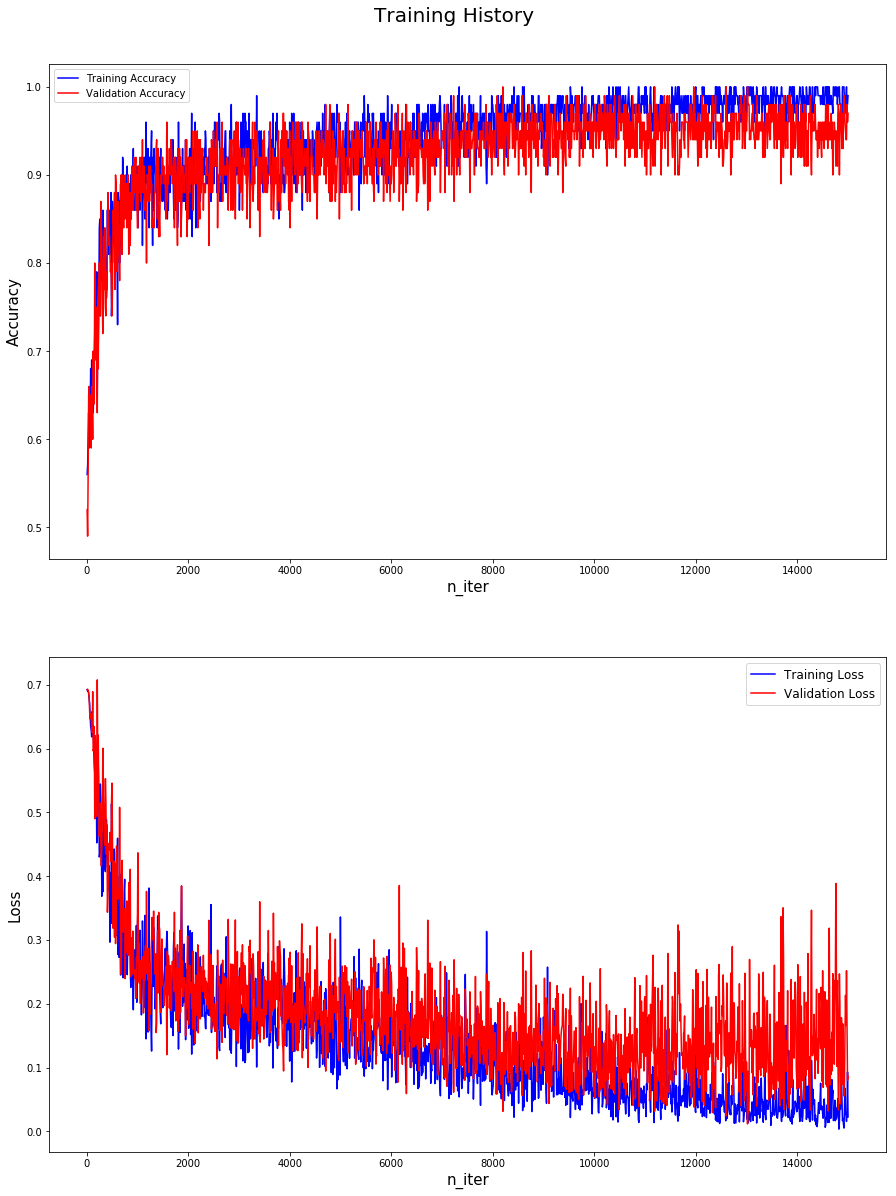

In [9]:
n_iter = 0
t_batch = 50
v_batch = 50
cal_interval = 10
prt_interval = 100
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
mean_loss_valid = []

hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
b
hist.plot(cal_interval)   

# sess.close()

In [ ]:
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = t_batch)
    d_train_x, d_train_y = load_random_minibatch(d_train_path, cls = 1, batch_size = t_batch)
    train_x = np.vstack([neg_train_x, d_train_x])
    train_y = np.vstack([neg_train_y, d_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: 1e-4})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = v_batch)
        d_valid_x, d_valid_y = load_random_minibatch(d_valid_path, cls = 1, batch_size = v_batch)
        valid_x = np.vstack([neg_valid_x, d_valid_x])
        valid_y = np.vstack([neg_valid_y, d_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)
        if n_iter >= 10:
            mean_loss_valid.append(np.mean(loss_valid[-10:]))
        if mean_loss_valid[-1] == np.min(mean_loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'ND_ES2_{0}_{1}_mean_loss_val_{2:.6f}'.format(nowDatetime, n_iter, mean_loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 25000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    
train2_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time + train2_time, early_stopping)


[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[15100] || 99.00 %    || 96.00 %    || 0.02088169 || 0.20700981
--------------------------------------------------------------
[15200] || 98.00 %    || 97.00 %    || 0.03885530 || 0.12046869
--------------------------------------------------------------
[15300] || 100.00 %    || 93.00 %    || 0.01082851 || 0.26843917
--------------------------------------------------------------
[15400] || 100.00 %    || 99.00 %    || 0.01589498 || 0.07417300
--------------------------------------------------------------
[15500] || 100.00 %    || 95.00 %    || 0.00782921 || 0.15484951
--------------------------------------------------------------
[15600] || 99.00 %    || 97.00 %    || 0.05127849 || 0.09714894
--------------------------------------------------------------
[15700] || 96.00 %    || 97.00 %    || 0.04636103 || 0.11884075
--------------------------------------------------------------
[15800] || 98.00 %    || 97.00 %    || 0.0630

[21400] || 100.00 %    || 95.00 %    || 0.01258149 || 0.18350975
--------------------------------------------------------------
[21500] || 99.00 %    || 98.00 %    || 0.01285306 || 0.13844258
--------------------------------------------------------------
[21600] || 100.00 %    || 96.00 %    || 0.00286556 || 0.11129504
--------------------------------------------------------------
